In [2]:
import os
import cv2
import copy
import time
import glob
import random
import datetime
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from pycocotools.coco import COCO

import pprint
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T

from dataset import COCO_INSTANCE_CATEGORY_NAMES
from utils import colors, get_prediction, object_detection_api, instance_segmentation_api

loading annotations into memory...
Done (t=15.68s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


## Dataset / DataLoader

In [6]:
# I believe that train image will be performed well (test image, of course, will fail)
train_images = glob.glob('/DATASET/COCO-Dataset/images/train2017/*.jpg')
test_images = glob.glob('/DATASET/COCO-Dataset/images/test2017/*.jpg')

In [4]:
FIXED_IMAGE_SHAPE = (640, 480)

BASE_IMG_PATH = '/DATASET/COCO-Dataset/images'
BASE_ANN_PATH = '/DATASET/COCO-Dataset/annotations'

TRAIN_IMG_PATH = os.path.join(BASE_IMG_PATH, 'train2017')
TRAIN_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_train2017.json')

VALID_IMG_PATH = os.path.join(BASE_IMG_PATH, 'val2017')
VALID_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_val2017.json')

TEST_IMG_PATH = os.path.join(BASE_IMG_PATH, 'test2017')
# TEST_ANN_PATH = os.path.join(BASE_ANN_PATH, 'instances_test2017.json')  # NO DATA!

In [5]:
from torchvision.datasets import CocoDetection

dataset_coco_train = CocoDetection(root=TRAIN_IMG_PATH,
                                   annFile=TRAIN_ANN_PATH,
                                   transform=T.Compose(
                                       [T.ToTensor()]) # 함부로 Resize 하면 GT값 변경
                                   )

dataset_coco_valid = CocoDetection(root=VALID_IMG_PATH,
                                   annFile=VALID_ANN_PATH,
                                   transform=T.Compose(
                                       [T.ToTensor()])
                                   )

loading annotations into memory...
Done (t=13.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [7]:
dataset_coco_train

Dataset CocoDetection
    Number of datapoints: 118287
    Root location: /DATASET/COCO-Dataset/images/train2017
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
dataset_coco_valid

Dataset CocoDetection
    Number of datapoints: 5000
    Root location: /DATASET/COCO-Dataset/images/val2017
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Image1

In [9]:
X, y = dataset_coco_train[0]

In [10]:
X

tensor([[[0.0078, 0.0039, 0.0000,  ..., 0.5255, 0.5255, 0.5137],
         [0.0196, 0.0118, 0.0039,  ..., 0.5373, 0.5294, 0.5137],
         [0.0039, 0.0000, 0.0000,  ..., 0.5412, 0.5333, 0.5176],
         ...,
         [0.0118, 0.0235, 0.0275,  ..., 0.0000, 0.0157, 0.0392],
         [0.0196, 0.0196, 0.0275,  ..., 0.0510, 0.0235, 0.0118],
         [0.0157, 0.0196, 0.0275,  ..., 0.0039, 0.0078, 0.0078]],

        [[0.0941, 0.0902, 0.0863,  ..., 0.6706, 0.6706, 0.6588],
         [0.0980, 0.0902, 0.0863,  ..., 0.6824, 0.6745, 0.6588],
         [0.0824, 0.0784, 0.0745,  ..., 0.6863, 0.6784, 0.6627],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.0392, 0.0157],
         [0.0000, 0.0000, 0.0118,  ..., 0.0314, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0118,  ..., 0.0118, 0.0118, 0.0196]],

        [[0.4275, 0.4275, 0.4235,  ..., 0.7725, 0.7725, 0.7647],
         [0.4392, 0.4392, 0.4353,  ..., 0.7843, 0.7765, 0.7608],
         [0.4314, 0.4275, 0.4353,  ..., 0.7882, 0.7804, 0.

In [11]:
y

[{'segmentation': [[500.49,
    473.53,
    599.73,
    419.6,
    612.67,
    375.37,
    608.36,
    354.88,
    528.54,
    269.66,
    457.35,
    201.71,
    420.67,
    187.69,
    389.39,
    192.0,
    19.42,
    360.27,
    1.08,
    389.39,
    2.16,
    427.15,
    20.49,
    473.53]],
  'area': 120057.13925,
  'iscrowd': 0,
  'image_id': 9,
  'bbox': [1.08, 187.69, 611.59, 285.84],
  'category_id': 51,
  'id': 1038967},
 {'segmentation': [[357.03,
    69.03,
    311.73,
    15.1,
    550.11,
    4.31,
    631.01,
    62.56,
    629.93,
    88.45,
    595.42,
    185.53,
    513.44,
    230.83,
    488.63,
    232.99,
    437.93,
    190.92,
    429.3,
    189.84,
    434.7,
    148.85,
    410.97,
    121.89,
    359.19,
    74.43,
    358.11,
    65.8]],
  'area': 44434.751099999994,
  'iscrowd': 0,
  'image_id': 9,
  'bbox': [311.73, 4.31, 319.28, 228.68],
  'category_id': 51,
  'id': 1039564},
 {'segmentation': [[249.6,
    348.99,
    267.67,
    311.72,
    291.39,
   

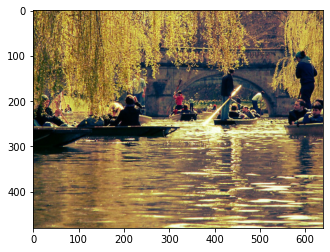

In [12]:
img1 = cv2.imread(train_images[300]) # Read image with cv2
img1 = cv2.resize(img1, FIXED_IMAGE_SHAPE)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Convert to RGB
plt.imshow(img1)
# plt.axis('off')
plt.show()

## Image2

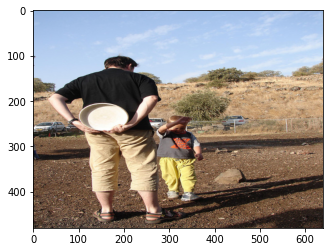

In [13]:
img2 = cv2.imread(train_images[400]) # Read image with cv2
img2 = cv2.resize(img2, FIXED_IMAGE_SHAPE)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # Convert to RGB
plt.imshow(img2)
# plt.axis('off')
plt.show()

## Cutout some part of image

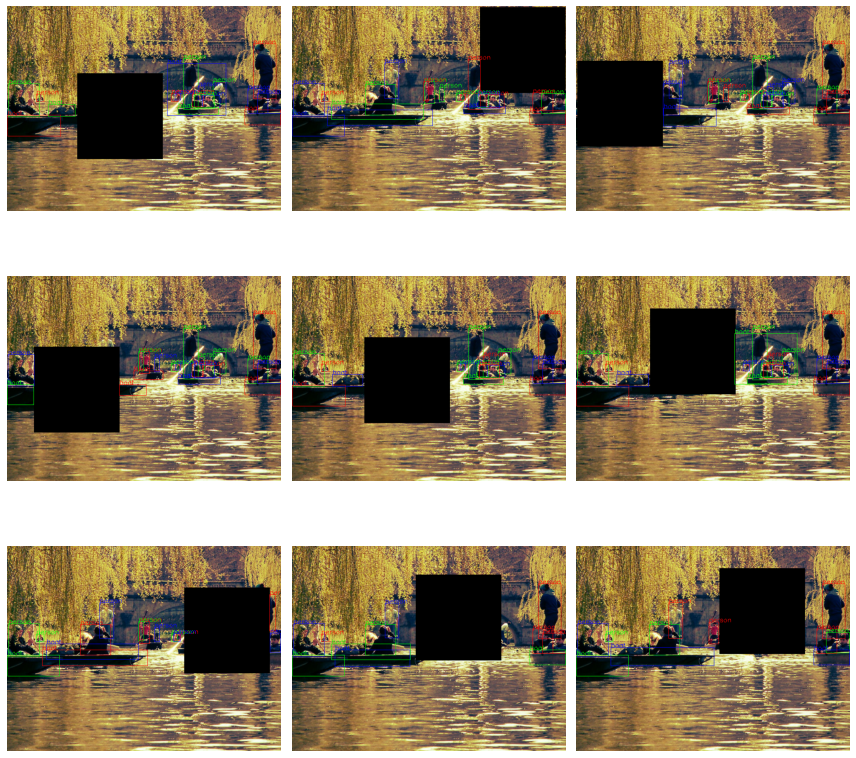

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

plt.figure(figsize=(12,12))

for idx, _ in enumerate(range(9), start=1):
    cutout_img = copy.deepcopy(img1)
    p1x = np.random.randint(0, 200)
    p1y = np.random.randint(0, 480)
    cutout_img[p1x:p1x+200, p1y:p1y+200] = 0
    img = T.ToPILImage(mode='RGB')(cutout_img)
    img = T.ToTensor()(img)

    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > 0.5]
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    img = cutout_img
    colors = [(255,0,0),(0,255,0), (0,0,255)]
    for n, (pred_box, pred_cls) in enumerate(zip(pred_boxes,pred_class)):
        p1, p2 = pred_box
        cv2.rectangle(img, p1, p2 ,color=colors[n%3] , thickness=1) 
        cv2.putText(img, pred_cls, p1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[n%3])

    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Mixup different two images

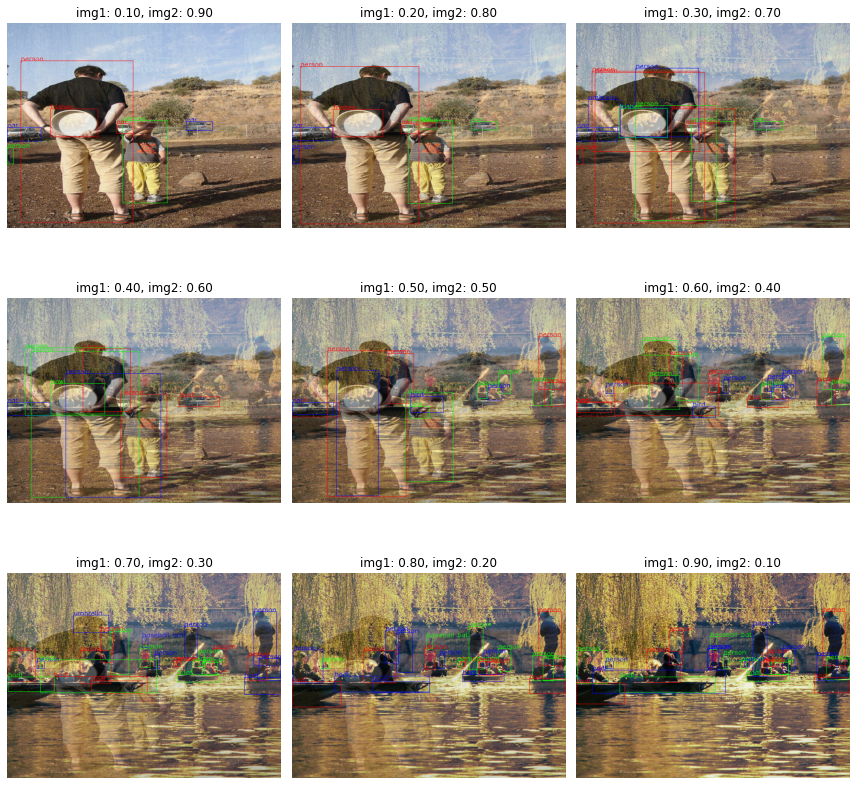

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

plt.figure(figsize=(12,12))

for idx, alpha in enumerate(np.arange(0.1,1.0,0.1), start=1):
    blend_img = cv2.addWeighted(img1, alpha, img2, 1-alpha, 0)
    img = T.ToPILImage(mode='RGB')(blend_img)
    img = T.ToTensor()(img)
    
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > 0.5]
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    img = blend_img
    colors = [(255,0,0),(0,255,0), (0,0,255)]
    for n, (pred_box, pred_cls) in enumerate(zip(pred_boxes,pred_class)):
        p1, p2 = pred_box
        cv2.rectangle(img, p1, p2 ,color=colors[n%3] , thickness=1) 
        cv2.putText(img, pred_cls, p1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[n%3])

    plt.subplot(3, 3, idx)
    plt.title(f"img1: {alpha:0.2f}, img2: {1-alpha:0.2f}")
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Cutmix two different images

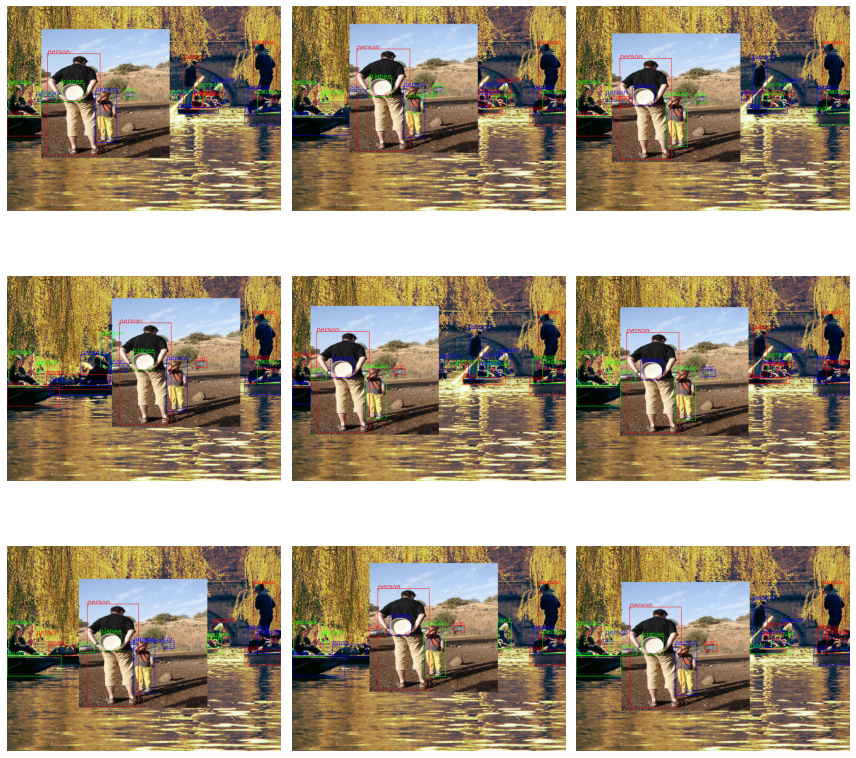

In [16]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

plt.figure(figsize=(12,12))

for idx, _ in enumerate(range(9), start=1):
    cutmix_img = copy.deepcopy(img1)
    p1x = np.random.randint(0, 100)
    p1y = np.random.randint(0, 300)
    cutmix_img[p1x:p1x+300, p1y:p1y+300] = cv2.resize(img2, (300,300))
    img = T.ToPILImage(mode='RGB')(cutmix_img)
    img = T.ToTensor()(img)

    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > 0.5]
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    img = cutmix_img
    colors = [(255,0,0),(0,255,0), (0,0,255)]
    for n, (pred_box, pred_cls) in enumerate(zip(pred_boxes,pred_class)):
        p1, p2 = pred_box
        cv2.rectangle(img, p1, p2 ,color=colors[n%3] , thickness=1) 
        cv2.putText(img, pred_cls, p1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[n%3])

    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## High-pass Frequency / Low-pass Frequency

## REPORT
- Try to find difference bewteen MIXUP images
    - These diff mean that model's weakness (ONLY Humans could)

- Sugget NOVEL metric for highly cluttered images in COCO Dataset
    - Mixup or Cutmix two images then calculate mAP!!
    - But only for COCO dataset but idea is cool (I think)

## Ref.

- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=samsjang&logNo=220505080672